In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import pickle
import sklearn
import re

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier

from collections import defaultdict

import matplotlib.pyplot as plt

from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.weightstats import ttest_ind

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

ImportError: cannot import name 'animation'

### Read data

In [2]:
recs_1 = pd.read_csv("../data/recommendations/recommendations_strat_1_clean.csv").drop("Unnamed: 0", axis=1)
recs_2 = pd.read_csv("../data/recommendations/recommendations_strat_2_clean.csv").drop("Unnamed: 0", axis=1)
recs_3 = pd.read_csv("../data/recommendations/recommendations_strat_3_clean.csv").drop("Unnamed: 0", axis=1)
recs_4 = pd.read_csv("../data/recommendations/recommendations_strat_4_clean.csv").drop("Unnamed: 0", axis=1).dropna()

In [3]:
equal = pd.read_csv("../data/training_videos.csv").drop("Unnamed: 0", axis = 1)
equal["full_text"].fillna("", inplace=True)

### Vectorize 

In [4]:
# Vectorize words
v = TfidfVectorizer(max_df=.75, min_df=2)
x = v.fit_transform(equal['full_text'])

In [5]:
X = x
Y = equal['conspiracy'].values.ravel()

### Train or load model

In [6]:
try:
    svm = pickle.load(open('SVM_trained.sav', 'rb'))
except:
    # Train
    svm = SVC(C=10, kernel="rbf", max_iter = 10000).fit(X, Y)

    # save the model to disk
    pickle.dump(svm, open('SVM_trained.sav', 'wb'))

In [7]:
try:
    mlp = pickle.load(open('MLP_trained.sav', 'rb'))
except:
    mlp = MLPClassifier(hidden_layer_sizes=[10]*10, activation="identity",
                        random_state=0).fit(X, Y)
    
    pickle.dump(mlp, open("MLP_trained.sav", 'wb'))

### Transform recommendations to tf-idf

In [8]:
recs_tfidf_1 = v.transform(recs_1["full_text"].values)
recs_tfidf_2 = v.transform(recs_2["full_text"].values)
recs_tfidf_3 = v.transform(recs_3["full_text"].values)
recs_tfidf_4 = v.transform(recs_4["full_text"].values)

### Predictions

In [9]:
try:
    combined = pd.read_csv("predicted.csv")
except:    
    recs_1["conspiracy_pred"] = svm.predict(recs_tfidf_1)
    recs_2["conspiracy_pred"] = svm.predict(recs_tfidf_2)
    recs_3["conspiracy_pred"] = svm.predict(recs_tfidf_3)
    recs_4["conspiracy_pred"] = svm.predict(recs_tfidf_4)
    
    recs_1["strategy"] = "strategy 1"
    recs_2["strategy"] = "strategy 2"
    recs_3["strategy"] = "strategy 3"
    recs_4["strategy"] = "strategy 4"
    
    combined = pd.concat([recs_1, recs_2, recs_3, recs_4], ignore_index=True)
    
    combined.to_csv("predicted.csv")

## Aggregates

In [10]:
# Select useful columns
combined = combined[["user", "strategy", "vids_watched",
                     "views", "likes", "dislikes",
                     "duration", "full_text", "conspiracy_pred"]].copy()

In [11]:
def to_seconds(duration):
    times = re.findall("\d+", duration)[::-1]
    return sum([int(times[i]) * 60**i for i in range(len(times))])

In [12]:
# Convert time to seconds
combined["duration"] = combined["duration"].apply(lambda x: to_seconds(str(x)))

In [13]:
# Group
grouped = combined.groupby(["strategy", "vids_watched"])

## Significance testing

In [14]:
def group(combined, strategy, i):
    return combined[(combined["strategy"] == strategy) & 
                    (combined["vids_watched"] == i)].groupby("user")["conspiracy_pred"].mean().values

In [15]:
results = defaultdict(dict)
sigs = defaultdict(list)

for strategy in ["strategy 2", "strategy 3", "strategy 4"]:
    for i in range(1, 16):
        # Calculate p-value for each strategy at each number of videos
        x = group(combined, "strategy 1", i)
        y = group(combined, strategy, i)
        results[strategy][i] = ttest_ind(x, y, alternative="smaller")[1]
    
for strat in results:
    for vid in results[strat]:
        # Store whether or not the results were significant
        if results[strat][vid] < 0.05:
            sigs[strat].append(True)
        else:
            sigs[strat].append(False)

## Pivot and plot

In [16]:
sns.set_theme(style="whitegrid")

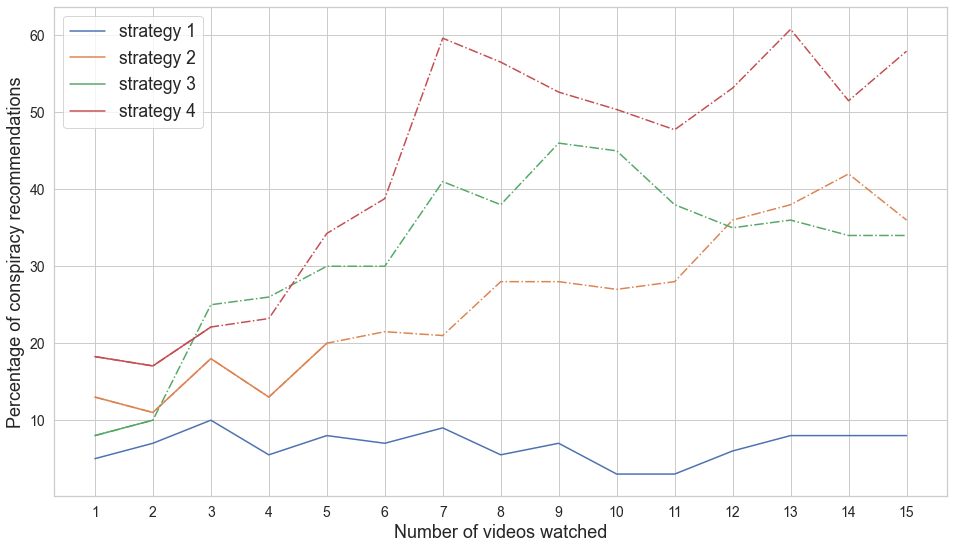

In [17]:
# Pivot
pivot = pd.pivot_table(combined,
                       index = ("strategy", "user"),
                       columns = "vids_watched",
                       values = "conspiracy_pred",
                       aggfunc = np.mean)

# Fill na with average of previous and next cell in column
pivot = (pivot.fillna(method="ffill", axis = 1) + pivot.fillna(method="bfill", axis = 1)) / 2 

grouped = pivot.groupby("strategy").mean()

# Plot
plt.figure(figsize=(16,9))

# Values and labels
x = grouped.columns
y = grouped.values * 100
labels = ["strategy 1", "strategy 2", "strategy 3", "strategy 4"]

# Get colors per label
colors = dict(zip(labels, sns.color_palette('deep', 4)))

for y_val, label in zip(y, labels):
    # Plot significance for strategies other than 1
    if label != "strategy 1":
        sig = np.array(sigs[label])
        sig[0] = False

        plt.plot(x[~sig], y_val[~sig], label=label, color=colors[label]);
        plt.plot(x, y_val, '-.', color=colors[label]);
    else:
        plt.plot(x, y_val, label=label)

plt.xticks(np.arange(1, 16, 1), fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Number of videos watched", fontsize=18);
plt.ylabel("Percentage of conspiracy recommendations", fontsize=18);

plt.legend(loc="upper left", prop = {"size": 17.5})
# plt.savefig('conspiracy_recs.pdf')

### Split strategy into individual users

<AxesSubplot:xlabel='vids_watched'>

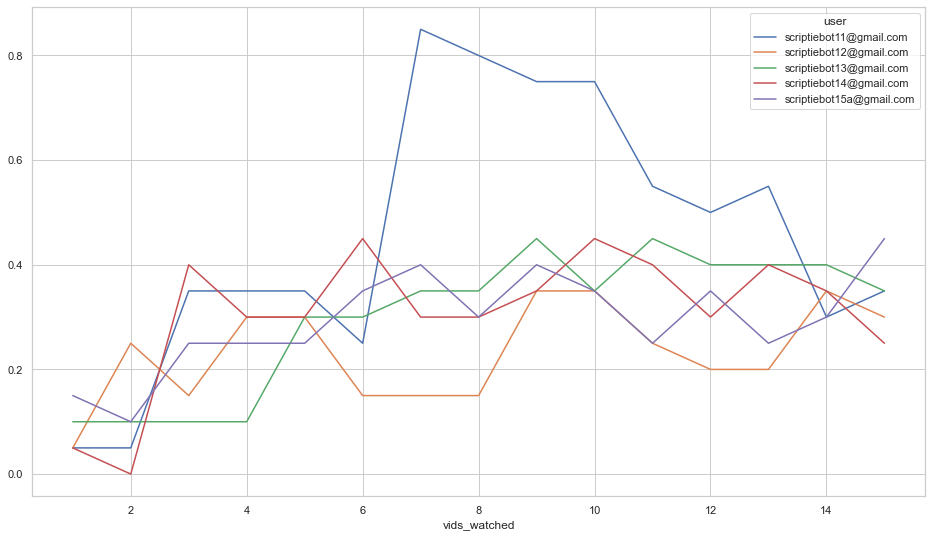

In [96]:
pivot.loc["strategy 3"].T.plot(figsize=(16,9))

# Similarity measures

In [98]:
combined["full_text"]

0       If 2 egg 1 glass oat make recip 5 minut If 2 e...
1       chillhop radio jazzi lofi hip hop beat welcom ...
2       ajax doc legaci johan cruijff johan cruijff le...
3       live broadcast the holi quran channel makkah l...
4       7 basic principl kemet ancient egyptian spirit...
                              ...                        
5770    get rid eye floater talk dr berg keto consult ...
5771    randi skeet sermon three crowd happi sabbath p...
5772    china built someth insan xinjiang world s long...
5773    mother allen s hummingbird hatch two egg feed ...
5774    pieter derk minut council minist www.pieterder...
Name: full_text, Length: 5775, dtype: object

In [99]:
similarities = combined.groupby(["user", "strategy",
                                 "vids_watched"])["full_text"].apply(lambda x: 
                                                                     cosine_similarity(v.transform(x)))

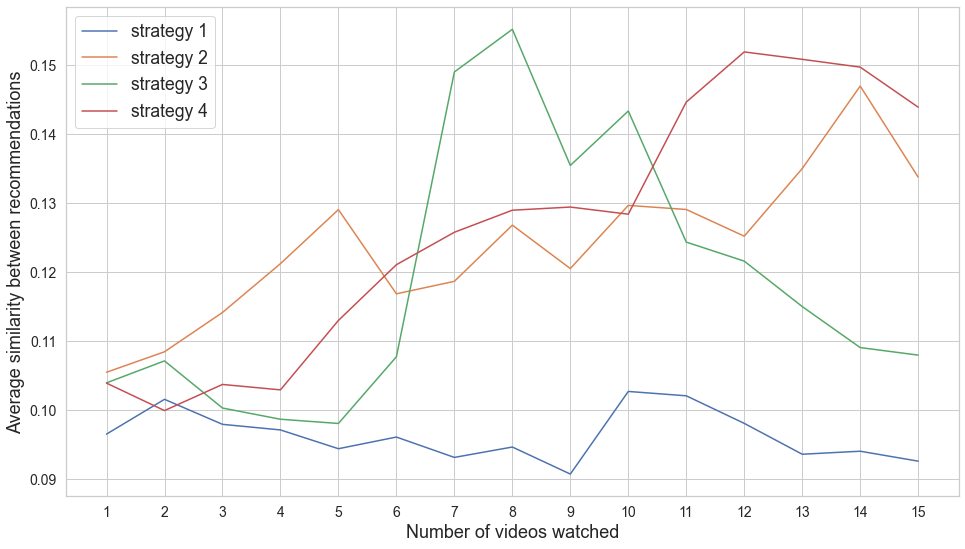

In [100]:
similarities.apply(np.mean).groupby(["strategy", "vids_watched"]).mean().unstack().T.plot(figsize=(16, 9))

plt.ylabel("Average similarity between recommendations", fontsize=18);
plt.xlabel("Number of videos watched", fontsize=18);

plt.xticks(np.arange(1, 16, 1), fontsize=14);
plt.yticks(fontsize=14);

plt.legend(loc="upper left", prop = {"size": 17.5});
plt.savefig('similarity.pdf')

# Experiment 2 results

## Retrieve data

In [101]:
recs_2_2 = pd.read_csv("../data/recommendations/recommendations_strat_2_exp_2_clean.csv").drop("Unnamed: 0", axis = 1)
recs_3_2 = pd.read_csv("../data/recommendations/recommendations_strat_3_exp_2_clean.csv").drop("Unnamed: 0", axis = 1)
recs_4_2 = pd.read_csv("../data/recommendations/recommendations_strat_4_exp_2_clean.csv").drop("Unnamed: 0", axis = 1)

In [102]:
recs_tfidf_2_2 = v.transform(recs_2_2["full_text"].values)
recs_tfidf_3_2 = v.transform(recs_3_2["full_text"].values)
recs_tfidf_4_2 = v.transform(recs_4_2["full_text"].values)

In [103]:
try:
    combined_2 = pd.read_csv("predicted_2.csv")
except:    
    recs_1["conspiracy_pred"] = svm.predict(recs_tfidf_1)
    recs_2_2["conspiracy_pred"] = svm.predict(recs_tfidf_2_2)
    recs_3_2["conspiracy_pred"] = svm.predict(recs_tfidf_3_2)
    recs_4_2["conspiracy_pred"] = svm.predict(recs_tfidf_4_2)
    
    recs_1["strategy"] = "strategy 1"
    recs_2_2["strategy"] = "strategy 2"
    recs_3_2["strategy"] = "strategy 3"
    recs_4_2["strategy"] = "strategy 4"
    
    combined_2 = pd.concat([recs_1, recs_2_2, recs_3_2, recs_4_2], ignore_index=True)
    
    combined_2.to_csv("predicted_2.csv")

In [104]:
combined_2["duration"] = combined_2["duration"].apply(lambda x: to_seconds(str(x)))

In [105]:
combined_2.head()

,Unnamed: 0,user,vids_watched,vid,views,likes,dislikes,duration,full_text,conspiracy_pred,strategy,channel
0,0,scriptiebot1@gmail.com,1,Jjge2pYKuUM,6708535.0,124784.0,5625.0,303,If 2 egg 1 glass oat make recip 5 minut If 2 e...,False,strategy 1,NaN
1,1,scriptiebot1@gmail.com,1,5yx6BWlEVcY,22824307.0,236476.0,4479.0,0,chillhop radio jazzi lofi hip hop beat welcom ...,False,strategy 1,NaN
2,2,scriptiebot1@gmail.com,1,Bj9PLkKNF-c,83168.0,1456.0,12.0,2900,ajax doc legaci johan cruijff johan cruijff le...,False,strategy 1,NaN
3,3,scriptiebot1@gmail.com,1,SMNHZR1u6KQ,8784881.0,103138.0,3495.0,0,live broadcast the holi quran channel makkah l...,False,strategy 1,NaN
4,4,scriptiebot1@gmail.com,1,46siYNcHMxM,408031.0,10729.0,380.0,3481,7 basic principl kemet ancient egyptian spirit...,False,strategy 1,NaN


In [106]:
results_2 = defaultdict(dict)
sigs_2 = defaultdict(list)

for strategy in ["strategy 2", "strategy 3", "strategy 4"]:
    for i in range(1, 16):
        # Calculate p-value for each strategy at each number of videos
        x = group(combined_2, "strategy 1", i)
        y = group(combined_2, strategy, i)
        results_2[strategy][i] = ttest_ind(x, y, alternative="smaller")[1]
    
for strat in results_2:
    for vid in results[strat]:
        # Store whether or not the results were significant
        if results[strat][vid] < 0.05:
            sigs_2[strat].append(True)
        else:
            sigs_2[strat].append(False)
            
sigs_2

defaultdict(list,
            {'strategy 2': [True,
              False,
              False,
              False,
              False,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True],
             'strategy 3': [False,
              False,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True],
             'strategy 4': [True,
              False,
              False,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True,
              True]})

## Plot

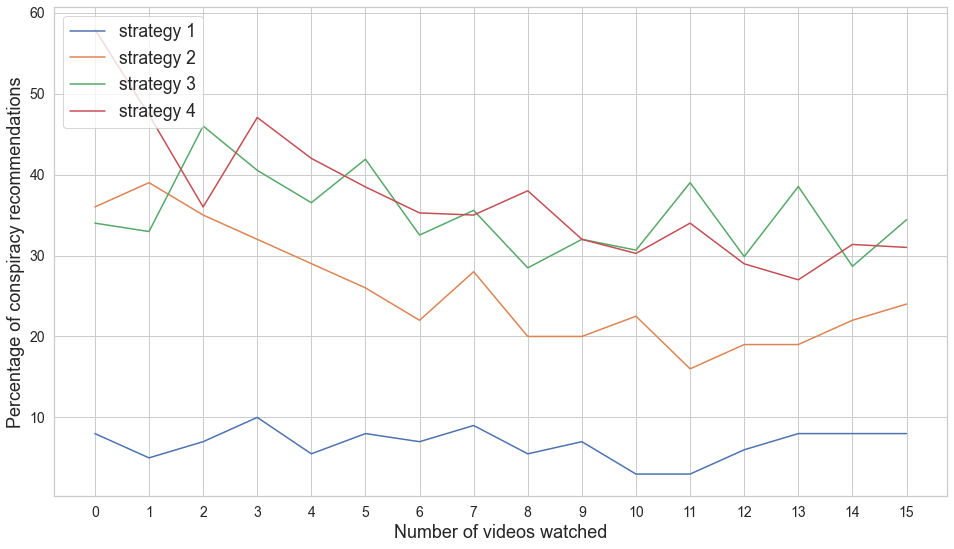

In [33]:
# Pivot
pivot_2 = pd.pivot_table(combined_2,
                         index = ("strategy", "user"),
                         columns = "vids_watched",
                         values = "conspiracy_pred",
                         aggfunc = np.mean)

# Fill na with average of previous and next cell in column
pivot_2 = (pivot_2.fillna(method="ffill", axis = 1) + pivot_2.fillna(method="bfill", axis = 1)) / 2 

grouped_2 = pivot_2.groupby("strategy").mean()

grouped_2[0] = grouped[15]
grouped_2 = grouped_2[range(16)]

# Plot
plt.figure(figsize=(16,9))

x = grouped_2.columns
y = grouped_2.values * 100
labels = ["strategy 1", "strategy 2", "strategy 3", "strategy 4"]

for y_val, label in zip(y, labels):
    plt.plot(x, y_val, label=label);

plt.xticks(np.arange(0, 16, 1), fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Number of videos watched", fontsize=18);
plt.ylabel("Percentage of conspiracy recommendations", fontsize=18);

plt.legend(loc="upper left", prop = {"size": 17.5})

plt.savefig('conspiracy_recs_2.pdf')
plt.show()